In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load text data
text_data_path = 'F:/MS Thesis/RND/BanglaText.csv'
df_text = pd.read_csv(text_data_path)

# Encode emotion labels
label_encoder = LabelEncoder()
df_text['Encoded_Emotion'] = label_encoder.fit_transform(df_text['Emotion'])
y_text = df_text['Encoded_Emotion']

# Tokenization and Padding for text data
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 100

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
text_tokenizer.fit_on_texts(df_text['Cleaned_Text'])
X_text = text_tokenizer.texts_to_sequences(df_text['Cleaned_Text'])
X_text = tf.keras.preprocessing.sequence.pad_sequences(X_text, maxlen=MAX_SEQ_LEN)

# Split text data
X_text_train, X_text_temp, y_text_train, y_text_temp = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(
    X_text_temp, y_text_temp, test_size=0.5, random_state=42, stratify=y_text_temp
)

# Load voice features and labels
voice_features_path = 'F:/MS Thesis/Research/Data/features.npy'
voice_labels_path = 'F:/MS Thesis/Research/Data/labels.npy'
features_voice = np.load(voice_features_path)
labels_voice = np.load(voice_labels_path)

# Encode voice labels
labels_voice_encoded = label_encoder.transform(labels_voice)

# Split voice data
X_voice_train, X_voice_temp, y_voice_train, y_voice_temp = train_test_split(
    features_voice, labels_voice_encoded, test_size=0.2, random_state=42, stratify=labels_voice_encoded
)
X_voice_val, X_voice_test, y_voice_val, y_voice_test = train_test_split(
    X_voice_temp, y_voice_temp, test_size=0.5, random_state=42, stratify=y_voice_temp
)

# Text Model
input_text = Input(shape=(MAX_SEQ_LEN,))
embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(input_text)
conv1d = Conv1D(128, kernel_size=5, activation='relu')(embedding)
global_pool = GlobalMaxPooling1D()(conv1d)

# Voice input
input_voice = Input(shape=(features_voice.shape[1],))
normalized_voice = BatchNormalization()(input_voice)

# Fusion for Early Fusion
fused_early = Concatenate()([global_pool, normalized_voice])

# Dense layers after fusion for Early Fusion
fusion_dense1 = Dense(128, activation='relu')(fused_early)
fusion_dropout1 = Dropout(0.5)(fusion_dense1)
fusion_dense2 = Dense(64, activation='relu')(fusion_dropout1)
fusion_dropout2 = Dropout(0.5)(fusion_dense2)

# Output for Early Fusion
output_early = Dense(len(label_encoder.classes_), activation='softmax')(fusion_dropout2)

# Compile early fusion model
early_fusion_model = Model(inputs=[input_text, input_voice], outputs=output_early)
early_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train Early Fusion Model
early_fusion_model.fit(
    [X_text_train, X_voice_train], y_text_train,
    validation_data=([X_text_val, X_voice_val], y_text_val),
    epochs=30,
    batch_size=32
)

# Predict and evaluate for Early Fusion
y_pred_early = np.argmax(early_fusion_model.predict([X_text_test, X_voice_test]), axis=1)
f1_early = f1_score(y_text_test, y_pred_early, average='weighted')
print("Early Fusion F1 Score:", f1_early)

# Train Text Model (for Late Fusion)
text_model_output = Dense(len(label_encoder.classes_), activation='softmax')(global_pool)
text_model = Model(inputs=input_text, outputs=text_model_output)

# Compile Text Model
text_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train Text Model
text_model.fit(
    X_text_train, y_text_train,
    validation_data=(X_text_val, y_text_val),
    epochs=10,  # Reduced for demonstration
    batch_size=32
)

# Predict with Text Model (Softmax Probabilities)
text_test_preds = text_model.predict(X_text_test)

# Train Voice Model (XGBoost) for Late Fusion
voice_dtrain = xgb.DMatrix(X_voice_train, label=y_voice_train)
voice_dval = xgb.DMatrix(X_voice_val, label=y_voice_val)
voice_dtest = xgb.DMatrix(X_voice_test, label=y_voice_test)

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.8
}

voice_model = xgb.train(params=xgb_params, dtrain=voice_dtrain, num_boost_round=100)

# Predict with Voice Model (Probabilities)
voice_test_preds = voice_model.predict(voice_dtest)
voice_test_preds = tf.keras.utils.to_categorical(voice_test_preds, num_classes=len(label_encoder.classes_))

# Late Fusion (Weighted Averaging)
alpha = 0.6  # Weight for text model
beta = 0.4   # Weight for voice model

# Make sure the dimensions of both predictions match
fused_probs = alpha * text_test_preds + beta * voice_test_preds

# Final Prediction
y_pred_late = np.argmax(fused_probs, axis=1)
f1_late = f1_score(y_text_test, y_pred_late, average='weighted')
print("Late Fusion (Weighted Averaging) F1 Score:", f1_late)


E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.2483 - loss: 1.7322 - val_accuracy: 0.3700 - val_loss: 1.5405
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4172 - loss: 1.4566 - val_accuracy: 0.5567 - val_loss: 1.1833
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6289 - loss: 1.0343 - val_accuracy: 0.6550 - val_loss: 0.9001
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8354 - loss: 0.5073 - val_accuracy: 0.7017 - val_loss: 0.9124
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9244 - loss: 0.2626 - val_accuracy: 0.6917 - val_loss: 1.0163
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9605 - loss: 0.1690 - val_accuracy: 0.6917 - val_loss: 1.1369
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9692 - loss: 0.1443 - val_accuracy: 0.6967 - val_loss: 1.1519
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.9715 - loss: 0.1059 - 

Early Fusion Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.70      0.69       100
     disgust       0.66      0.64      0.65       100
        fear       0.77      0.81      0.79       100
       happy       0.75      0.61      0.67       100
         sad       0.61      0.59      0.60       100
    surprise       0.61      0.72      0.66       100

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600



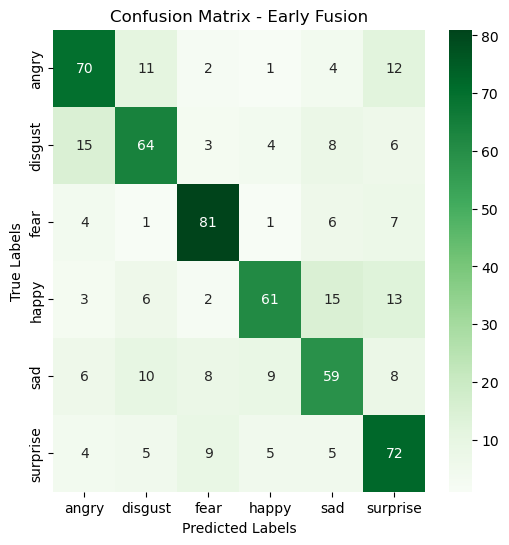

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report for Early Fusion
print("Early Fusion Classification Report:")
print(classification_report(y_text_test, y_pred_early, target_names=label_encoder.classes_))

# Confusion Matrix for Early Fusion
cm_early = confusion_matrix(y_text_test, y_pred_early)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_early, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Early Fusion')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Late Fusion Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.71      0.72       100
     disgust       0.80      0.72      0.76       100
        fear       0.80      0.84      0.82       100
       happy       0.75      0.68      0.71       100
         sad       0.63      0.67      0.65       100
    surprise       0.74      0.82      0.78       100

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600



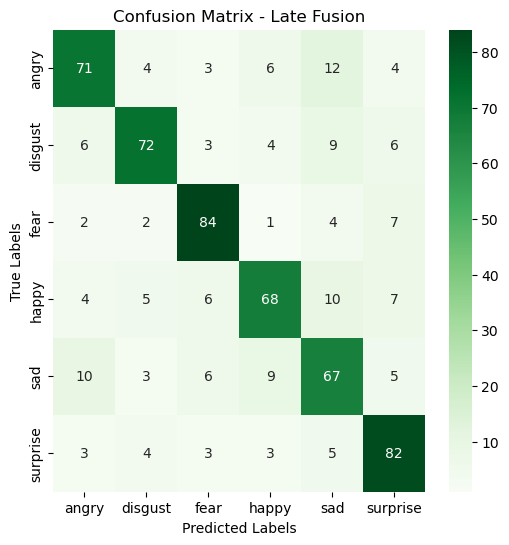

In [16]:
# Classification Report for Late Fusion
print("Late Fusion Classification Report:")
print(classification_report(y_text_test, y_pred_late, target_names=label_encoder.classes_))

# Confusion Matrix for Late Fusion
cm_late = confusion_matrix(y_text_test, y_pred_late)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_late, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Late Fusion')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
